In [1]:
# Cell 1 - imports and settings
# imports
import os
import time
import math
import random
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Settings
VARIANT_NAME = "resolution_64X64_quality_50"
PREPROC_ROOT = Path("preprocessed_variants_2")
VARIANT_PATH = PREPROC_ROOT / VARIANT_NAME
RESULTS_DIR = Path("models_results_3")
MODELS_DIR = Path("models_3")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Training settings
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 40
AUTO = tf.data.AUTOTUNE

print("Variant path:", VARIANT_PATH.resolve())
print("Results dir:", RESULTS_DIR.resolve())

Variant path: C:\Users\jjgca\Documents\2025-2\Machine Learning Aplicado\Personal\preprocessed_variants_2\resolution_64X64_quality_50
Results dir: C:\Users\jjgca\Documents\2025-2\Machine Learning Aplicado\Personal\models_results_3


In [2]:
# Cell 2 - discover classes on disk and create stratified splits (train/val/test = 60/20/20)
# We generate splits here (not reusing previous splits) so experiments are self-contained.

assert VARIANT_PATH.exists(), f"Variant folder not found: {VARIANT_PATH}"

# discover class folders
class_folders = sorted([p for p in VARIANT_PATH.iterdir() if p.is_dir()])
class_names_on_disk = [p.name for p in class_folders]
if len(class_names_on_disk) == 0:
    raise RuntimeError("No class folders found in variant path.")

print("Detected classes:", class_names_on_disk)

# gather files per class
extensions = ('.jpg', '.jpeg', '.png')
rows = []
for cls_folder in class_folders:
    files = sorted([p for p in cls_folder.glob("*") if p.suffix.lower() in extensions])
    for f in files:
        rows.append({'filepath': str(f.resolve()), 'class': cls_folder.name})

all_files_df = pd.DataFrame(rows)
total_images = len(all_files_df)
print("Total images found:", total_images)

# stratified split per class using numpy RNG for reproducibility
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.6, 0.2, 0.2
rng = np.random.default_rng(SEED)

split_rows = []
for cls in class_names_on_disk:
    subset = all_files_df[all_files_df['class'] == cls].reset_index(drop=True)
    n = len(subset)
    if n == 0:
        continue
    perm = rng.permutation(n)
    n_train = int(np.floor(TRAIN_FRAC * n))
    n_val = int(np.floor(VAL_FRAC * n))
    train_idx = perm[:n_train]
    val_idx = perm[n_train:n_train + n_val]
    test_idx = perm[n_train + n_val:]
    for i in train_idx:
        split_rows.append({'filepath': subset.loc[i, 'filepath'], 'class': cls, 'split': 'train'})
    for i in val_idx:
        split_rows.append({'filepath': subset.loc[i, 'filepath'], 'class': cls, 'split': 'val'})
    for i in test_idx:
        split_rows.append({'filepath': subset.loc[i, 'filepath'], 'class': cls, 'split': 'test'})

splits_df = pd.DataFrame(split_rows)
# quick sanity check
counts = splits_df.groupby(['class','split']).size().unstack(fill_value=0)
print("Per-class counts (train/val/test):")
print(counts)

# save splits for traceability
splits_csv = RESULTS_DIR / f"splits_{VARIANT_NAME}.csv"
splits_df.to_csv(splits_csv, index=False)
print("Saved splits CSV to:", splits_csv.resolve())

# create train/val/test dataframes
train_df = splits_df[splits_df['split']=='train'].reset_index(drop=True)
val_df   = splits_df[splits_df['split']=='val'].reset_index(drop=True)
test_df  = splits_df[splits_df['split']=='test'].reset_index(drop=True)
print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))


Detected classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
Total images found: 18159
Per-class counts (train/val/test):
split                                          test  train   val
class                                                           
Tomato___Bacterial_spot                         426   1276   425
Tomato___Early_blight                           200    600   200
Tomato___Late_blight                            383   1144   381
Tomato___Leaf_Mold                              191    571   190
Tomato___Septoria_leaf_spot                     355   1062   354
Tomato___Spider_mites Two-spotted_spider_mite   336   1005   335
Tomato___Target_Spot                            282    842   280
Tomato___Tomato_Yellow_Leaf_Curl_Virus 

In [3]:
# Cell 3 - build tf.data datasets from the DataFrames
# We map class names to indices deterministically using class_names_on_disk order.

class_to_index = {c:i for i,c in enumerate(class_names_on_disk)}
NUM_CLASSES = len(class_names_on_disk)
print("NUM_CLASSES:", NUM_CLASSES)

def df_to_tf_dataset(df, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False, seed=SEED):
    filepaths = df['filepath'].tolist()
    labels = [class_to_index[c] for c in df['class'].tolist()]
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def _load(path, label):
        img = tf.io.read_file(path)
        # decode jpeg or png (try jpeg first; assume images are jpg as created)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        img = tf.image.resize(img, image_size)
        return img, label

    ds = ds.map(lambda p,l: _load(p,l), num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(buffer_size=2000, seed=seed)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds

train_ds = df_to_tf_dataset(train_df, shuffle=True)
val_ds   = df_to_tf_dataset(val_df, shuffle=False)
test_ds  = df_to_tf_dataset(test_df, shuffle=False)

# quick inspect shapes
for xb, yb in train_ds.take(1):
    print("Train batch shape:", xb.shape, yb.shape)
for xb, yb in val_ds.take(1):
    print("Val batch shape:", xb.shape, yb.shape)
for xb, yb in test_ds.take(1):
    print("Test batch shape:", xb.shape, yb.shape)


NUM_CLASSES: 10
Train batch shape: (32, 64, 64, 3) (32,)
Val batch shape: (32, 64, 64, 3) (32,)
Test batch shape: (32, 64, 64, 3) (32,)


In [4]:
# Cell 4 - helper functions for metrics, model size and latency measurement

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'confusion_matrix': cm}

def evaluate_model(model, dataset):
    # Predict all samples in dataset and compute metrics
    preds = model.predict(dataset, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    y_true = []
    for _, yb in dataset:
        y_true.extend(yb.numpy().tolist())
    y_true = np.array(y_true)
    return compute_metrics(y_true, pred_labels)

def model_size_bytes(model):
    # save temporarily to measure size
    tmp = tempfile.NamedTemporaryFile(suffix=".h5", delete=False)
    tmp.close()
    try:
        model.save(tmp.name, include_optimizer=False)
        return os.path.getsize(tmp.name)
    finally:
        try:
            os.remove(tmp.name)
        except Exception:
            pass

def measure_latency_ms(model, dataset, n_warmup=3, n_iters=30):
    # Measure per-sample latency (CPU) using batches from dataset
    # Warm-up
    it = iter(dataset)
    for _ in range(n_warmup):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(dataset)
            xb, _ = next(it)
        _ = model.predict(xb, verbose=0)

    # timed runs
    times = []
    it = iter(dataset)
    for _ in range(n_iters):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(dataset)
            xb, _ = next(it)
        t0 = time.perf_counter()
        _ = model.predict(xb, verbose=0)
        t1 = time.perf_counter()
        per_sample = (t1 - t0) / xb.shape[0]
        times.append(per_sample * 1000.0)  # ms
    return float(np.mean(times)), float(np.std(times))


In [5]:
# Cell 5 - model builders: base model and several variations derived from it

def build_base_from_general(input_shape=(64,64,3), n_classes=NUM_CLASSES, use_gap=True, bn=True, dropout=0.4):
    # similar to the model used in general_model.ipynb (baseline)
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    if use_gap:
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)

    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

def build_more_layers(input_shape=(64,64,3), n_classes=NUM_CLASSES):
    # deeper variant: add one more conv block and slightly larger dense
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(256,3,padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

def build_fewer_layers(input_shape=(64,64,3), n_classes=NUM_CLASSES):
    # shallower variant: fewer filters and fewer blocks
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16,3,padding='same',activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

def build_no_batchnorm(input_shape=(64,64,3), n_classes=NUM_CLASSES):
    # variant with BatchNorm removed
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inputs)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

def build_extra_dense(input_shape=(64,64,3), n_classes=NUM_CLASSES):
    # variant with extra dense layers to increase capacity
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

def build_depthwise_variant(input_shape=(64,64,3), n_classes=NUM_CLASSES):
    # variant using depthwise separable style blocks (efficient)
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(24,3,padding='same',activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.DepthwiseConv2D(3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32,1,activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.DepthwiseConv2D(3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64,1,activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# list of variants - (name, builder function)
MODEL_VARIANTS = [
    ("Base_original", build_base_from_general),
    ("More_layers", build_more_layers),
    ("Fewer_layers", build_fewer_layers),
    ("No_BatchNorm", build_no_batchnorm),
    ("Extra_dense", build_extra_dense),
    ("Depthwise_variant", build_depthwise_variant),
]

print("Model variants to evaluate:", [m[0] for m in MODEL_VARIANTS])


Model variants to evaluate: ['Base_original', 'More_layers', 'Fewer_layers', 'No_BatchNorm', 'Extra_dense', 'Depthwise_variant']


In [6]:
# Cell 6 - training loop: train each model variant, evaluate on test, measure sizes and latency

results = []

# compute class weights to mitigate imbalance
y_train = train_df['class'].map(class_to_index).tolist()
unique_classes = np.unique(y_train)
class_weights_arr = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight = {int(c): float(w) for c,w in zip(unique_classes, class_weights_arr)}
print("Using class_weight:", class_weight)

for name, builder in MODEL_VARIANTS:
    print("\n\n========== Running variant:", name, "==========")
    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # build and compile
    model = builder(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), n_classes=NUM_CLASSES) \
            if 'n_classes' in builder.__code__.co_varnames else builder()
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    # callbacks
    ckpt_path = MODELS_DIR / f"{VARIANT_NAME}__{name}__best.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(str(ckpt_path), monitor='val_loss', save_best_only=True, save_weights_only=False)
    ]

    # train
    t0 = time.perf_counter()
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                        callbacks=callbacks, class_weight=class_weight, verbose=2)
    train_secs = time.perf_counter() - t0
    print(f"Training time (s): {train_secs:.2f}")

    # evaluate on test set (final metrics)
    test_metrics = evaluate_model(model, test_ds)
    print("Test metrics:", test_metrics)

    # params and model size
    n_params = model.count_params()
    size_b = model_size_bytes(model)
    size_mb = size_b / (1024*1024)

    # inference latency measurement
    try:
        lat_mean_ms, lat_std_ms = measure_latency_ms(model, test_ds, n_warmup=3, n_iters=30)
    except Exception as e:
        print("Latency measurement failed:", e)
        lat_mean_ms, lat_std_ms = None, None

    # save history and confusion matrix
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(RESULTS_DIR / f"history_{VARIANT_NAME}_{name}.csv", index=False)
    np.save(RESULTS_DIR / f"cm_{VARIANT_NAME}_{name}.npy", test_metrics['confusion_matrix'])

    # collect result record
    record = {
        'variant': VARIANT_NAME,
        'model_name': name,
        'n_params': int(n_params),
        'model_size_mb': float(round(size_mb, 4)),
        'train_time_seconds': float(round(train_secs, 2)),
        'test_accuracy': float(test_metrics['accuracy']),
        'test_precision_macro': float(test_metrics['precision']),
        'test_recall_macro': float(test_metrics['recall']),
        'test_f1_macro': float(test_metrics['f1']),
        'latency_mean_ms': lat_mean_ms,
        'latency_std_ms': lat_std_ms,
        'checkpoint_path': str(ckpt_path)
    }
    results.append(record)

    # cleanup
    del model
    tf.keras.backend.clear_session()

# save results summary
results_df = pd.DataFrame(results).sort_values(by='test_f1_macro', ascending=False)
out_csv = RESULTS_DIR / f"models_variants_comparison_{VARIANT_NAME}.csv"
results_df.to_csv(out_csv, index=False)
print("Saved summary to:", out_csv.resolve())
display(results_df)


Using class_weight: {0: 0.8535266457680251, 1: 1.8151666666666666, 2: 1.1416142557651991, 3: 0.9520104895104895, 4: 1.907355516637478, 5: 1.025517890772128, 6: 1.083681592039801, 7: 1.2934679334916865, 8: 4.8838565022421525, 9: 0.33886123210952085}


========== Running variant: Base_original ==========



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 21s - 62ms/step - accuracy: 0.5984 - loss: 1.3307 - val_accuracy: 0.5926 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 2/40
341/341 - 19s - 57ms/step - accuracy: 0.6494 - loss: 1.1213 - val_accuracy: 0.4126 - val_loss: 2.8043 - learning_rate: 0.0010
Epoch 3/40
341/341 - 20s - 58ms/step - accuracy: 0.6738 - loss: 1.0062 - val_accuracy: 0.4013 - val_loss: 2.5753 - learning_rate: 0.0010
Epoch 4/40
341/341 - 20s - 58ms/step - accuracy: 0.7099 - loss: 0.8706 - val_accuracy: 0.5460 - val_loss: 1.6747 - learning_rate: 0.0010
Epoch 5/40


341/341 - 20s - 58ms/step - accuracy: 0.6985 - loss: 0.8787 - val_accuracy: 0.6502 - val_loss: 0.9386 - learning_rate: 5.0000e-04
Epoch 6/40
341/341 - 20s - 59ms/step - accuracy: 0.7193 - loss: 0.8006 - val_accuracy: 0.6318 - val_loss: 1.0060 - learning_rate: 5.0000e-04
Epoch 7/40


341/341 - 19s - 57ms/step - accuracy: 0.7307 - loss: 0.7700 - val_accuracy: 0.6442 - val_loss: 0.9005 - learning_rate: 5.0000e-04
Epoch 8/40


341/341 - 20s - 58ms/step - accuracy: 0.7524 - loss: 0.7160 - val_accuracy: 0.6891 - val_loss: 0.8230 - learning_rate: 5.0000e-04
Epoch 9/40
341/341 - 20s - 58ms/step - accuracy: 0.7648 - loss: 0.6688 - val_accuracy: 0.4799 - val_loss: 1.7634 - learning_rate: 5.0000e-04
Epoch 10/40
341/341 - 20s - 58ms/step - accuracy: 0.7817 - loss: 0.6600 - val_accuracy: 0.6224 - val_loss: 1.1116 - learning_rate: 5.0000e-04
Epoch 11/40
341/341 - 20s - 57ms/step - accuracy: 0.7852 - loss: 0.6222 - val_accuracy: 0.6816 - val_loss: 0.8731 - learning_rate: 5.0000e-04
Epoch 12/40
341/341 - 20s - 57ms/step - accuracy: 0.7575 - loss: 0.6723 - val_accuracy: 0.6750 - val_loss: 0.8594 - learning_rate: 2.5000e-04
Epoch 13/40


341/341 - 20s - 59ms/step - accuracy: 0.7705 - loss: 0.6350 - val_accuracy: 0.7445 - val_loss: 0.6754 - learning_rate: 2.5000e-04
Epoch 14/40


341/341 - 21s - 61ms/step - accuracy: 0.7849 - loss: 0.6060 - val_accuracy: 0.7811 - val_loss: 0.5822 - learning_rate: 2.5000e-04
Epoch 15/40


341/341 - 20s - 58ms/step - accuracy: 0.7917 - loss: 0.5855 - val_accuracy: 0.7850 - val_loss: 0.5552 - learning_rate: 2.5000e-04
Epoch 16/40
341/341 - 20s - 58ms/step - accuracy: 0.8076 - loss: 0.5577 - val_accuracy: 0.7853 - val_loss: 0.5728 - learning_rate: 2.5000e-04
Epoch 17/40


341/341 - 20s - 58ms/step - accuracy: 0.8047 - loss: 0.5515 - val_accuracy: 0.8197 - val_loss: 0.5155 - learning_rate: 2.5000e-04
Epoch 18/40


341/341 - 20s - 57ms/step - accuracy: 0.8123 - loss: 0.5452 - val_accuracy: 0.8264 - val_loss: 0.4656 - learning_rate: 2.5000e-04
Epoch 19/40


341/341 - 20s - 58ms/step - accuracy: 0.8230 - loss: 0.5199 - val_accuracy: 0.8525 - val_loss: 0.4655 - learning_rate: 2.5000e-04
Epoch 20/40
341/341 - 20s - 57ms/step - accuracy: 0.8202 - loss: 0.5187 - val_accuracy: 0.7541 - val_loss: 0.6847 - learning_rate: 2.5000e-04
Epoch 21/40
341/341 - 20s - 57ms/step - accuracy: 0.8281 - loss: 0.4936 - val_accuracy: 0.8186 - val_loss: 0.5090 - learning_rate: 2.5000e-04
Epoch 22/40


341/341 - 20s - 58ms/step - accuracy: 0.8301 - loss: 0.4959 - val_accuracy: 0.8592 - val_loss: 0.4257 - learning_rate: 2.5000e-04
Epoch 23/40
341/341 - 20s - 58ms/step - accuracy: 0.8341 - loss: 0.4701 - val_accuracy: 0.8509 - val_loss: 0.4345 - learning_rate: 2.5000e-04
Epoch 24/40
341/341 - 20s - 58ms/step - accuracy: 0.8397 - loss: 0.4617 - val_accuracy: 0.8476 - val_loss: 0.4342 - learning_rate: 2.5000e-04
Epoch 25/40
341/341 - 20s - 59ms/step - accuracy: 0.8504 - loss: 0.4472 - val_accuracy: 0.8308 - val_loss: 0.4851 - learning_rate: 2.5000e-04
Epoch 26/40
341/341 - 20s - 58ms/step - accuracy: 0.8304 - loss: 0.4829 - val_accuracy: 0.8365 - val_loss: 0.4480 - learning_rate: 1.2500e-04
Epoch 27/40


341/341 - 20s - 58ms/step - accuracy: 0.8351 - loss: 0.4743 - val_accuracy: 0.8605 - val_loss: 0.3821 - learning_rate: 1.2500e-04
Epoch 28/40


341/341 - 20s - 58ms/step - accuracy: 0.8468 - loss: 0.4530 - val_accuracy: 0.8740 - val_loss: 0.3684 - learning_rate: 1.2500e-04
Epoch 29/40


341/341 - 20s - 58ms/step - accuracy: 0.8498 - loss: 0.4295 - val_accuracy: 0.8903 - val_loss: 0.3309 - learning_rate: 1.2500e-04
Epoch 30/40
341/341 - 20s - 60ms/step - accuracy: 0.8532 - loss: 0.4201 - val_accuracy: 0.8616 - val_loss: 0.3954 - learning_rate: 1.2500e-04
Epoch 31/40
341/341 - 20s - 58ms/step - accuracy: 0.8551 - loss: 0.4234 - val_accuracy: 0.8740 - val_loss: 0.3536 - learning_rate: 1.2500e-04
Epoch 32/40
341/341 - 20s - 58ms/step - accuracy: 0.8588 - loss: 0.4260 - val_accuracy: 0.8834 - val_loss: 0.3551 - learning_rate: 1.2500e-04
Epoch 33/40


341/341 - 20s - 59ms/step - accuracy: 0.8535 - loss: 0.4311 - val_accuracy: 0.9030 - val_loss: 0.2775 - learning_rate: 6.2500e-05
Epoch 34/40
341/341 - 20s - 59ms/step - accuracy: 0.8532 - loss: 0.4268 - val_accuracy: 0.9049 - val_loss: 0.2809 - learning_rate: 6.2500e-05
Epoch 35/40
341/341 - 20s - 58ms/step - accuracy: 0.8552 - loss: 0.4193 - val_accuracy: 0.8986 - val_loss: 0.2970 - learning_rate: 6.2500e-05
Epoch 36/40
341/341 - 20s - 58ms/step - accuracy: 0.8501 - loss: 0.4305 - val_accuracy: 0.9057 - val_loss: 0.2795 - learning_rate: 6.2500e-05
Epoch 37/40


341/341 - 20s - 58ms/step - accuracy: 0.8550 - loss: 0.4344 - val_accuracy: 0.9190 - val_loss: 0.2466 - learning_rate: 3.1250e-05
Epoch 38/40


341/341 - 20s - 58ms/step - accuracy: 0.8556 - loss: 0.4137 - val_accuracy: 0.9212 - val_loss: 0.2381 - learning_rate: 3.1250e-05
Epoch 39/40
341/341 - 20s - 58ms/step - accuracy: 0.8597 - loss: 0.4128 - val_accuracy: 0.9201 - val_loss: 0.2434 - learning_rate: 3.1250e-05
Epoch 40/40
341/341 - 20s - 59ms/step - accuracy: 0.8643 - loss: 0.4005 - val_accuracy: 0.9220 - val_loss: 0.2382 - learning_rate: 3.1250e-05
Training time (s): 793.49


Test metrics: {'accuracy': 0.9203296703296703, 'precision': 0.9111344019041736, 'recall': 0.9056144825254847, 'f1': 0.9067837215495249, 'confusion_matrix': array([[ 359,    1,    1,    3,    0,    3,    0,    7,    0,   52],
       [   3,  145,    0,   28,    0,    5,    3,    8,    3,    5],
       [   0,    0,  304,    0,    1,    1,    0,   11,    0,    2],
       [   3,   26,    1,  338,    3,    4,    0,    1,    0,    7],
       [   0,    0,    0,    5,  175,    5,    2,    0,    1,    3],
       [   1,    2,    0,    4,    6,  331,    1,    4,    4,    2],
       [   0,    2,    2,    0,    0,    0,  299,   26,    2,    5],
       [   0,    0,    2,    0,    1,    1,    8,  265,    0,    5],
       [   0,    0,    0,    0,    0,    1,    0,    0,   75,    0],
       [   4,    2,    0,    2,    1,    0,    4,    0,    0, 1059]],
      dtype=int64)}


========== Running variant: More_layers ==========


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,522 (1.62 MB)

 Trainable params: 423,562 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/40


341/341 - 26s - 75ms/step - accuracy: 0.7204 - loss: 1.0510 - val_accuracy: 0.2949 - val_loss: 7.7086 - learning_rate: 0.0010
Epoch 2/40


341/341 - 24s - 69ms/step - accuracy: 0.7452 - loss: 0.8901 - val_accuracy: 0.3859 - val_loss: 3.2474 - learning_rate: 0.0010
Epoch 3/40
341/341 - 23s - 68ms/step - accuracy: 0.7794 - loss: 0.7298 - val_accuracy: 0.3490 - val_loss: 4.6810 - learning_rate: 0.0010
Epoch 4/40


341/341 - 23s - 67ms/step - accuracy: 0.7844 - loss: 0.6964 - val_accuracy: 0.6080 - val_loss: 1.3502 - learning_rate: 0.0010
Epoch 5/40
341/341 - 23s - 68ms/step - accuracy: 0.7989 - loss: 0.6285 - val_accuracy: 0.3377 - val_loss: 3.3998 - learning_rate: 0.0010
Epoch 6/40


341/341 - 23s - 68ms/step - accuracy: 0.8130 - loss: 0.5826 - val_accuracy: 0.6695 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 7/40
341/341 - 23s - 68ms/step - accuracy: 0.8156 - loss: 0.5596 - val_accuracy: 0.4901 - val_loss: 1.8486 - learning_rate: 0.0010
Epoch 8/40
341/341 - 23s - 67ms/step - accuracy: 0.8241 - loss: 0.5142 - val_accuracy: 0.5584 - val_loss: 1.7019 - learning_rate: 0.0010
Epoch 9/40
341/341 - 23s - 68ms/step - accuracy: 0.8482 - loss: 0.4678 - val_accuracy: 0.4595 - val_loss: 3.0916 - learning_rate: 0.0010
Epoch 10/40


341/341 - 23s - 68ms/step - accuracy: 0.8419 - loss: 0.4751 - val_accuracy: 0.7646 - val_loss: 0.7377 - learning_rate: 5.0000e-04
Epoch 11/40
341/341 - 23s - 67ms/step - accuracy: 0.8578 - loss: 0.4154 - val_accuracy: 0.6841 - val_loss: 1.0269 - learning_rate: 5.0000e-04
Epoch 12/40
341/341 - 23s - 67ms/step - accuracy: 0.8678 - loss: 0.3939 - val_accuracy: 0.7456 - val_loss: 0.7667 - learning_rate: 5.0000e-04
Epoch 13/40
341/341 - 24s - 69ms/step - accuracy: 0.8749 - loss: 0.3772 - val_accuracy: 0.7296 - val_loss: 0.8621 - learning_rate: 5.0000e-04
Epoch 14/40


341/341 - 23s - 67ms/step - accuracy: 0.8705 - loss: 0.3744 - val_accuracy: 0.8192 - val_loss: 0.5095 - learning_rate: 2.5000e-04
Epoch 15/40


341/341 - 23s - 67ms/step - accuracy: 0.8786 - loss: 0.3427 - val_accuracy: 0.8412 - val_loss: 0.4658 - learning_rate: 2.5000e-04
Epoch 16/40
341/341 - 23s - 67ms/step - accuracy: 0.8898 - loss: 0.3169 - val_accuracy: 0.8156 - val_loss: 0.5742 - learning_rate: 2.5000e-04
Epoch 17/40
341/341 - 23s - 68ms/step - accuracy: 0.8985 - loss: 0.2951 - val_accuracy: 0.7845 - val_loss: 0.7233 - learning_rate: 2.5000e-04
Epoch 18/40
341/341 - 23s - 67ms/step - accuracy: 0.9047 - loss: 0.2817 - val_accuracy: 0.8550 - val_loss: 0.5181 - learning_rate: 2.5000e-04
Epoch 19/40


341/341 - 23s - 68ms/step - accuracy: 0.8882 - loss: 0.3117 - val_accuracy: 0.8964 - val_loss: 0.3359 - learning_rate: 1.2500e-04
Epoch 20/40


341/341 - 23s - 67ms/step - accuracy: 0.8957 - loss: 0.2888 - val_accuracy: 0.9038 - val_loss: 0.2968 - learning_rate: 1.2500e-04
Epoch 21/40


341/341 - 23s - 68ms/step - accuracy: 0.9049 - loss: 0.2575 - val_accuracy: 0.9192 - val_loss: 0.2416 - learning_rate: 1.2500e-04
Epoch 22/40
341/341 - 23s - 69ms/step - accuracy: 0.9088 - loss: 0.2505 - val_accuracy: 0.9126 - val_loss: 0.2652 - learning_rate: 1.2500e-04
Epoch 23/40
341/341 - 24s - 69ms/step - accuracy: 0.9087 - loss: 0.2562 - val_accuracy: 0.9187 - val_loss: 0.2589 - learning_rate: 1.2500e-04
Epoch 24/40


341/341 - 24s - 70ms/step - accuracy: 0.9141 - loss: 0.2418 - val_accuracy: 0.9325 - val_loss: 0.2027 - learning_rate: 1.2500e-04
Epoch 25/40
341/341 - 24s - 69ms/step - accuracy: 0.9182 - loss: 0.2402 - val_accuracy: 0.9049 - val_loss: 0.3064 - learning_rate: 1.2500e-04
Epoch 26/40
341/341 - 23s - 68ms/step - accuracy: 0.9206 - loss: 0.2270 - val_accuracy: 0.9245 - val_loss: 0.2399 - learning_rate: 1.2500e-04
Epoch 27/40
341/341 - 23s - 68ms/step - accuracy: 0.9242 - loss: 0.2177 - val_accuracy: 0.9123 - val_loss: 0.2811 - learning_rate: 1.2500e-04
Epoch 28/40
341/341 - 23s - 67ms/step - accuracy: 0.9137 - loss: 0.2335 - val_accuracy: 0.9305 - val_loss: 0.2173 - learning_rate: 6.2500e-05
Epoch 29/40


341/341 - 23s - 67ms/step - accuracy: 0.9243 - loss: 0.2084 - val_accuracy: 0.9383 - val_loss: 0.1960 - learning_rate: 6.2500e-05
Epoch 30/40


341/341 - 23s - 68ms/step - accuracy: 0.9304 - loss: 0.1951 - val_accuracy: 0.9451 - val_loss: 0.1709 - learning_rate: 6.2500e-05
Epoch 31/40
341/341 - 23s - 67ms/step - accuracy: 0.9313 - loss: 0.1978 - val_accuracy: 0.9399 - val_loss: 0.1966 - learning_rate: 6.2500e-05
Epoch 32/40
341/341 - 23s - 68ms/step - accuracy: 0.9333 - loss: 0.1860 - val_accuracy: 0.9402 - val_loss: 0.1938 - learning_rate: 6.2500e-05
Epoch 33/40
341/341 - 23s - 68ms/step - accuracy: 0.9343 - loss: 0.1850 - val_accuracy: 0.9418 - val_loss: 0.1884 - learning_rate: 6.2500e-05
Epoch 34/40
341/341 - 23s - 67ms/step - accuracy: 0.9290 - loss: 0.2020 - val_accuracy: 0.9427 - val_loss: 0.1787 - learning_rate: 3.1250e-05
Epoch 35/40
341/341 - 23s - 68ms/step - accuracy: 0.9321 - loss: 0.1889 - val_accuracy: 0.9402 - val_loss: 0.1825 - learning_rate: 3.1250e-05
Epoch 36/40
341/341 - 23s - 67ms/step - accuracy: 0.9319 - loss: 0.1940 - val_accuracy: 0.9429 - val_loss: 0.1726 - learning_rate: 3.1250e-05
Training time (s):

Test metrics: {'accuracy': 0.9357142857142857, 'precision': 0.9375908602352734, 'recall': 0.9259087487370412, 'f1': 0.930087250411353, 'confusion_matrix': array([[ 349,    2,    0,    2,    0,    1,    0,    7,    0,   65],
       [   1,  155,    1,   16,    0,    2,    9,    5,    1,   10],
       [   0,    0,  312,    0,    0,    0,    1,    5,    0,    1],
       [   0,   16,    3,  350,    1,    1,    1,    1,    0,   10],
       [   0,    0,    0,    3,  182,    2,    3,    0,    0,    1],
       [   1,    0,    0,    4,    5,  335,    2,    2,    4,    2],
       [   0,    1,    1,    0,    0,    0,  322,   10,    0,    2],
       [   0,    0,    1,    0,    1,    1,   14,  261,    1,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,   76,    0],
       [   0,    1,    0,    0,    0,    0,    6,    1,    0, 1064]],
      dtype=int64)}


========== Running variant: Fewer_layers ==========


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,042 (31.41 KB)

 Trainable params: 7,946 (31.04 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/40


341/341 - 10s - 30ms/step - accuracy: 0.5570 - loss: 1.4837 - val_accuracy: 0.3082 - val_loss: 2.0814 - learning_rate: 0.0010
Epoch 2/40
341/341 - 8s - 25ms/step - accuracy: 0.6098 - loss: 1.2502 - val_accuracy: 0.3106 - val_loss: 3.2263 - learning_rate: 0.0010
Epoch 3/40


341/341 - 8s - 25ms/step - accuracy: 0.6369 - loss: 1.1138 - val_accuracy: 0.4587 - val_loss: 1.5232 - learning_rate: 0.0010
Epoch 4/40
341/341 - 8s - 25ms/step - accuracy: 0.6829 - loss: 0.9422 - val_accuracy: 0.4628 - val_loss: 1.6693 - learning_rate: 0.0010
Epoch 5/40


341/341 - 8s - 25ms/step - accuracy: 0.7177 - loss: 0.8392 - val_accuracy: 0.6282 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 6/40
341/341 - 8s - 25ms/step - accuracy: 0.7474 - loss: 0.7451 - val_accuracy: 0.4570 - val_loss: 1.8008 - learning_rate: 0.0010
Epoch 7/40
341/341 - 8s - 24ms/step - accuracy: 0.7714 - loss: 0.6994 - val_accuracy: 0.3746 - val_loss: 2.6457 - learning_rate: 0.0010
Epoch 8/40
341/341 - 8s - 25ms/step - accuracy: 0.7800 - loss: 0.6681 - val_accuracy: 0.6596 - val_loss: 1.1796 - learning_rate: 0.0010
Epoch 9/40
341/341 - 8s - 24ms/step - accuracy: 0.7779 - loss: 0.6789 - val_accuracy: 0.6483 - val_loss: 1.0272 - learning_rate: 5.0000e-04
Epoch 10/40
341/341 - 9s - 26ms/step - accuracy: 0.7985 - loss: 0.6278 - val_accuracy: 0.4019 - val_loss: 2.4548 - learning_rate: 5.0000e-04
Epoch 11/40
341/341 - 9s - 25ms/step - accuracy: 0.8032 - loss: 0.6158 - val_accuracy: 0.6342 - val_loss: 1.1137 - learning_rate: 5.0000e-04
Training time (s): 94.44


Test metrics: {'accuracy': 0.6200549450549451, 'precision': 0.7558760049718123, 'recall': 0.5515958953994567, 'f1': 0.5493992285628053, 'confusion_matrix': array([[  62,    0,    0,    5,    0,    0,    0,    3,    0,  356],
       [   0,   16,    0,    5,    1,    4,   14,   25,    1,  134],
       [   0,    0,  286,   11,    0,    1,    1,   13,    2,    5],
       [   5,    1,    4,  138,   15,    9,   21,    8,    5,  177],
       [   0,    0,    3,    2,   54,   33,    4,    0,   10,   85],
       [   0,    0,    5,    1,    3,  190,    7,   42,   41,   66],
       [   0,    0,    1,    1,    0,    0,  144,   26,    2,  162],
       [   1,    0,    7,    0,    0,    1,   19,  223,    2,   29],
       [   0,    0,    0,    0,    0,    0,    0,    0,   76,    0],
       [   0,    0,    0,    1,    0,    0,    3,    0,    0, 1068]],
      dtype=int64)}


========== Running variant: No_BatchNorm ==========


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,154 (399.04 KB)

 Trainable params: 102,154 (399.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


341/341 - 11s - 31ms/step - accuracy: 0.3584 - loss: 1.9150 - val_accuracy: 0.3490 - val_loss: 2.4985 - learning_rate: 0.0010
Epoch 2/40


341/341 - 10s - 28ms/step - accuracy: 0.3984 - loss: 1.8071 - val_accuracy: 0.3247 - val_loss: 2.2660 - learning_rate: 0.0010
Epoch 3/40


341/341 - 10s - 28ms/step - accuracy: 0.4066 - loss: 1.7278 - val_accuracy: 0.3128 - val_loss: 2.1578 - learning_rate: 0.0010
Epoch 4/40
341/341 - 10s - 28ms/step - accuracy: 0.4308 - loss: 1.6566 - val_accuracy: 0.3164 - val_loss: 2.1626 - learning_rate: 0.0010
Epoch 5/40
341/341 - 10s - 28ms/step - accuracy: 0.4217 - loss: 1.6473 - val_accuracy: 0.3117 - val_loss: 2.3368 - learning_rate: 0.0010
Epoch 6/40
341/341 - 10s - 28ms/step - accuracy: 0.4041 - loss: 1.7026 - val_accuracy: 0.3060 - val_loss: 2.5612 - learning_rate: 0.0010
Epoch 7/40


341/341 - 10s - 28ms/step - accuracy: 0.4214 - loss: 1.6763 - val_accuracy: 0.3388 - val_loss: 2.1394 - learning_rate: 5.0000e-04
Epoch 8/40
341/341 - 10s - 28ms/step - accuracy: 0.4592 - loss: 1.6309 - val_accuracy: 0.3589 - val_loss: 2.1818 - learning_rate: 5.0000e-04
Epoch 9/40


341/341 - 10s - 29ms/step - accuracy: 0.4033 - loss: 1.6899 - val_accuracy: 0.3377 - val_loss: 1.9301 - learning_rate: 5.0000e-04
Epoch 10/40
341/341 - 10s - 29ms/step - accuracy: 0.4299 - loss: 1.6642 - val_accuracy: 0.3542 - val_loss: 2.2379 - learning_rate: 5.0000e-04
Epoch 11/40
341/341 - 10s - 29ms/step - accuracy: 0.4316 - loss: 1.6704 - val_accuracy: 0.3611 - val_loss: 2.1454 - learning_rate: 5.0000e-04
Epoch 12/40
341/341 - 10s - 29ms/step - accuracy: 0.4503 - loss: 1.6422 - val_accuracy: 0.3261 - val_loss: 2.1459 - learning_rate: 5.0000e-04
Epoch 13/40
341/341 - 10s - 29ms/step - accuracy: 0.3943 - loss: 1.7759 - val_accuracy: 0.3412 - val_loss: 2.3951 - learning_rate: 2.5000e-04
Epoch 14/40
341/341 - 10s - 29ms/step - accuracy: 0.4001 - loss: 1.8007 - val_accuracy: 0.3371 - val_loss: 2.1498 - learning_rate: 2.5000e-04
Epoch 15/40
341/341 - 10s - 29ms/step - accuracy: 0.3316 - loss: 1.8703 - val_accuracy: 0.2952 - val_loss: 2.4153 - learning_rate: 2.5000e-04
Training time (s):

Test metrics: {'accuracy': 0.33873626373626375, 'precision': 0.17160916772140342, 'recall': 0.22017372263031731, 'f1': 0.11857098428423832, 'confusion_matrix': array([[   0,    0,    0,    0,    0,    0,    0,    8,   52,  366],
       [   0,    1,    0,    6,    0,    0,    0,   14,   82,   97],
       [   0,    0,    0,    0,    0,    0,    0,   62,  175,   82],
       [   0,    9,    0,   38,    0,    0,    0,   60,  157,  119],
       [   0,    0,    0,    0,    0,    0,    0,    1,  129,   61],
       [   0,    1,    0,    1,    0,    0,    0,    9,  233,  111],
       [   0,    0,    0,    0,    0,    0,    0,   53,  129,  154],
       [   0,    1,    0,    0,    0,    0,    0,   63,  149,   69],
       [   0,    0,    0,    0,    0,    0,    0,    0,   67,    9],
       [   0,    0,    0,    0,    0,    0,    0,    1,    7, 1064]],
      dtype=int64)}


========== Running variant: Extra_dense ==========


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,562 (467.04 KB)

 Trainable params: 119,114 (465.29 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 23s - 68ms/step - accuracy: 0.6879 - loss: 1.1137 - val_accuracy: 0.0899 - val_loss: 7.5334 - learning_rate: 0.0010
Epoch 2/40


341/341 - 21s - 62ms/step - accuracy: 0.7484 - loss: 0.8566 - val_accuracy: 0.3724 - val_loss: 5.3140 - learning_rate: 0.0010
Epoch 3/40


341/341 - 21s - 62ms/step - accuracy: 0.7714 - loss: 0.7334 - val_accuracy: 0.4319 - val_loss: 2.9719 - learning_rate: 0.0010
Epoch 4/40


341/341 - 21s - 62ms/step - accuracy: 0.7883 - loss: 0.6576 - val_accuracy: 0.5030 - val_loss: 2.2231 - learning_rate: 0.0010
Epoch 5/40


341/341 - 20s - 60ms/step - accuracy: 0.8054 - loss: 0.5887 - val_accuracy: 0.5573 - val_loss: 1.6743 - learning_rate: 0.0010
Epoch 6/40


341/341 - 21s - 61ms/step - accuracy: 0.8235 - loss: 0.5436 - val_accuracy: 0.7178 - val_loss: 0.8176 - learning_rate: 0.0010
Epoch 7/40
341/341 - 20s - 60ms/step - accuracy: 0.8331 - loss: 0.4953 - val_accuracy: 0.6508 - val_loss: 1.1532 - learning_rate: 0.0010
Epoch 8/40
341/341 - 21s - 61ms/step - accuracy: 0.8501 - loss: 0.4452 - val_accuracy: 0.4945 - val_loss: 2.0058 - learning_rate: 0.0010
Epoch 9/40
341/341 - 21s - 63ms/step - accuracy: 0.8591 - loss: 0.4257 - val_accuracy: 0.5777 - val_loss: 1.5448 - learning_rate: 0.0010
Epoch 10/40
341/341 - 21s - 62ms/step - accuracy: 0.8554 - loss: 0.4158 - val_accuracy: 0.6320 - val_loss: 1.2539 - learning_rate: 5.0000e-04
Epoch 11/40
341/341 - 20s - 59ms/step - accuracy: 0.8783 - loss: 0.3718 - val_accuracy: 0.7023 - val_loss: 0.9536 - learning_rate: 5.0000e-04
Epoch 12/40


341/341 - 20s - 60ms/step - accuracy: 0.8858 - loss: 0.3427 - val_accuracy: 0.7817 - val_loss: 0.6885 - learning_rate: 5.0000e-04
Epoch 13/40
341/341 - 20s - 60ms/step - accuracy: 0.8827 - loss: 0.3485 - val_accuracy: 0.7453 - val_loss: 0.7980 - learning_rate: 5.0000e-04
Epoch 14/40
341/341 - 20s - 59ms/step - accuracy: 0.8973 - loss: 0.3019 - val_accuracy: 0.5667 - val_loss: 2.0202 - learning_rate: 5.0000e-04
Epoch 15/40
341/341 - 20s - 60ms/step - accuracy: 0.8945 - loss: 0.3145 - val_accuracy: 0.7053 - val_loss: 0.9660 - learning_rate: 5.0000e-04
Epoch 16/40


341/341 - 20s - 60ms/step - accuracy: 0.8915 - loss: 0.3241 - val_accuracy: 0.8600 - val_loss: 0.4598 - learning_rate: 2.5000e-04
Epoch 17/40
341/341 - 20s - 59ms/step - accuracy: 0.9000 - loss: 0.2882 - val_accuracy: 0.7897 - val_loss: 0.6867 - learning_rate: 2.5000e-04
Epoch 18/40
341/341 - 21s - 61ms/step - accuracy: 0.8998 - loss: 0.2802 - val_accuracy: 0.8159 - val_loss: 0.5685 - learning_rate: 2.5000e-04
Epoch 19/40


341/341 - 21s - 60ms/step - accuracy: 0.9033 - loss: 0.2721 - val_accuracy: 0.8818 - val_loss: 0.3864 - learning_rate: 2.5000e-04
Epoch 20/40
341/341 - 20s - 60ms/step - accuracy: 0.9031 - loss: 0.2733 - val_accuracy: 0.8845 - val_loss: 0.3864 - learning_rate: 2.5000e-04
Epoch 21/40
341/341 - 20s - 60ms/step - accuracy: 0.9108 - loss: 0.2512 - val_accuracy: 0.8451 - val_loss: 0.5052 - learning_rate: 2.5000e-04
Epoch 22/40


341/341 - 21s - 60ms/step - accuracy: 0.9088 - loss: 0.2483 - val_accuracy: 0.8873 - val_loss: 0.3592 - learning_rate: 2.5000e-04
Epoch 23/40
341/341 - 20s - 60ms/step - accuracy: 0.9164 - loss: 0.2461 - val_accuracy: 0.8768 - val_loss: 0.4179 - learning_rate: 2.5000e-04
Epoch 24/40


341/341 - 21s - 62ms/step - accuracy: 0.9137 - loss: 0.2403 - val_accuracy: 0.9212 - val_loss: 0.2622 - learning_rate: 2.5000e-04
Epoch 25/40
341/341 - 21s - 60ms/step - accuracy: 0.9205 - loss: 0.2245 - val_accuracy: 0.8933 - val_loss: 0.3453 - learning_rate: 2.5000e-04
Epoch 26/40


341/341 - 21s - 61ms/step - accuracy: 0.9228 - loss: 0.2136 - val_accuracy: 0.9170 - val_loss: 0.2541 - learning_rate: 2.5000e-04
Epoch 27/40
341/341 - 21s - 60ms/step - accuracy: 0.9217 - loss: 0.2241 - val_accuracy: 0.8175 - val_loss: 0.5762 - learning_rate: 2.5000e-04
Epoch 28/40


341/341 - 21s - 61ms/step - accuracy: 0.9302 - loss: 0.2052 - val_accuracy: 0.9176 - val_loss: 0.2488 - learning_rate: 2.5000e-04
Epoch 29/40
341/341 - 20s - 60ms/step - accuracy: 0.9309 - loss: 0.1938 - val_accuracy: 0.8881 - val_loss: 0.3408 - learning_rate: 2.5000e-04
Epoch 30/40
341/341 - 21s - 61ms/step - accuracy: 0.9376 - loss: 0.1859 - val_accuracy: 0.9016 - val_loss: 0.2767 - learning_rate: 2.5000e-04
Epoch 31/40
341/341 - 21s - 61ms/step - accuracy: 0.9312 - loss: 0.1860 - val_accuracy: 0.8804 - val_loss: 0.3782 - learning_rate: 2.5000e-04
Epoch 32/40


341/341 - 21s - 61ms/step - accuracy: 0.9254 - loss: 0.2108 - val_accuracy: 0.9242 - val_loss: 0.2357 - learning_rate: 1.2500e-04
Epoch 33/40
341/341 - 21s - 62ms/step - accuracy: 0.9299 - loss: 0.1960 - val_accuracy: 0.9179 - val_loss: 0.2476 - learning_rate: 1.2500e-04
Epoch 34/40
341/341 - 21s - 61ms/step - accuracy: 0.9308 - loss: 0.1905 - val_accuracy: 0.9090 - val_loss: 0.2985 - learning_rate: 1.2500e-04
Epoch 35/40
341/341 - 21s - 61ms/step - accuracy: 0.9351 - loss: 0.1799 - val_accuracy: 0.9107 - val_loss: 0.2770 - learning_rate: 1.2500e-04
Epoch 36/40


341/341 - 21s - 60ms/step - accuracy: 0.9230 - loss: 0.2132 - val_accuracy: 0.9311 - val_loss: 0.2043 - learning_rate: 6.2500e-05
Epoch 37/40
341/341 - 21s - 61ms/step - accuracy: 0.9253 - loss: 0.1962 - val_accuracy: 0.9264 - val_loss: 0.2094 - learning_rate: 6.2500e-05
Epoch 38/40
341/341 - 21s - 61ms/step - accuracy: 0.9267 - loss: 0.1972 - val_accuracy: 0.9300 - val_loss: 0.2064 - learning_rate: 6.2500e-05
Epoch 39/40


341/341 - 21s - 60ms/step - accuracy: 0.9304 - loss: 0.1864 - val_accuracy: 0.9363 - val_loss: 0.1895 - learning_rate: 6.2500e-05
Epoch 40/40


341/341 - 20s - 60ms/step - accuracy: 0.9310 - loss: 0.1901 - val_accuracy: 0.9366 - val_loss: 0.1821 - learning_rate: 6.2500e-05
Training time (s): 828.93


Test metrics: {'accuracy': 0.9384615384615385, 'precision': 0.9362413549063582, 'recall': 0.9305021876121271, 'f1': 0.9318666048066759, 'confusion_matrix': array([[ 349,    3,    0,    4,    1,    4,    0,    5,    0,   60],
       [   2,  166,    0,    8,    4,    3,    2,    5,    4,    6],
       [   0,    0,  309,    1,    2,    0,    0,    7,    0,    0],
       [   0,   11,    1,  352,    4,    6,    1,    2,    0,    6],
       [   0,    0,    0,    2,  182,    3,    1,    0,    1,    2],
       [   0,    1,    0,    4,    5,  340,    0,    2,    2,    1],
       [   0,    1,    1,    1,    0,    0,  315,    9,    1,    8],
       [   1,    0,    1,    0,    0,    2,   10,  261,    1,    6],
       [   0,    0,    0,    0,    0,    0,    0,    0,   76,    0],
       [   0,    1,    0,    3,    0,    1,    1,    0,    0, 1066]],
      dtype=int64)}


========== Running variant: Depthwise_variant ==========


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 24)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 64, 64, 24)     │           240 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 32, 32, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,306 (36.35 KB)

 Trainable params: 9,130 (35.66 KB)

 Non-trainable params: 176 (704.00 B)

Epoch 1/40


341/341 - 18s - 54ms/step - accuracy: 0.5277 - loss: 1.5253 - val_accuracy: 0.2952 - val_loss: 2.7004 - learning_rate: 0.0010
Epoch 2/40
341/341 - 17s - 49ms/step - accuracy: 0.6550 - loss: 1.0832 - val_accuracy: 0.3423 - val_loss: 3.5126 - learning_rate: 0.0010
Epoch 3/40
341/341 - 17s - 48ms/step - accuracy: 0.7272 - loss: 0.8884 - val_accuracy: 0.3641 - val_loss: 2.8502 - learning_rate: 0.0010
Epoch 4/40
341/341 - 17s - 49ms/step - accuracy: 0.7548 - loss: 0.7786 - val_accuracy: 0.3991 - val_loss: 2.9484 - learning_rate: 0.0010
Epoch 5/40


341/341 - 17s - 49ms/step - accuracy: 0.7155 - loss: 0.9119 - val_accuracy: 0.4948 - val_loss: 1.6196 - learning_rate: 5.0000e-04
Epoch 6/40
341/341 - 17s - 49ms/step - accuracy: 0.7468 - loss: 0.7819 - val_accuracy: 0.4909 - val_loss: 2.0107 - learning_rate: 5.0000e-04
Epoch 7/40


341/341 - 17s - 49ms/step - accuracy: 0.7569 - loss: 0.7680 - val_accuracy: 0.6891 - val_loss: 0.8792 - learning_rate: 5.0000e-04
Epoch 8/40
341/341 - 17s - 49ms/step - accuracy: 0.7688 - loss: 0.7076 - val_accuracy: 0.5719 - val_loss: 1.8650 - learning_rate: 5.0000e-04
Epoch 9/40
341/341 - 17s - 50ms/step - accuracy: 0.7853 - loss: 0.6523 - val_accuracy: 0.5695 - val_loss: 1.4298 - learning_rate: 5.0000e-04
Epoch 10/40
341/341 - 16s - 48ms/step - accuracy: 0.7989 - loss: 0.6132 - val_accuracy: 0.4589 - val_loss: 2.2911 - learning_rate: 5.0000e-04
Epoch 11/40
341/341 - 17s - 49ms/step - accuracy: 0.7720 - loss: 0.6696 - val_accuracy: 0.5460 - val_loss: 1.4372 - learning_rate: 2.5000e-04
Epoch 12/40
341/341 - 17s - 49ms/step - accuracy: 0.7830 - loss: 0.6274 - val_accuracy: 0.5551 - val_loss: 1.3291 - learning_rate: 2.5000e-04
Epoch 13/40
341/341 - 17s - 49ms/step - accuracy: 0.7932 - loss: 0.5927 - val_accuracy: 0.5992 - val_loss: 1.1286 - learning_rate: 2.5000e-04
Training time (s): 2

Test metrics: {'accuracy': 0.6862637362637363, 'precision': 0.719371458446039, 'recall': 0.6091789915271613, 'f1': 0.5884908313658185, 'confusion_matrix': array([[ 322,    0,    0,    2,    0,    4,    0,   19,    0,   79],
       [  18,   10,    0,   26,    1,    2,   10,   26,    6,  101],
       [   2,    0,  226,    6,    0,    0,    2,   76,    6,    1],
       [  16,    0,    6,  154,   27,   13,   22,    9,   21,  115],
       [   0,    0,    0,    4,   76,   26,    4,    0,   17,   64],
       [   0,    0,    0,    1,   15,  187,   20,   37,   64,   31],
       [   0,    0,    0,    0,    0,    2,  154,   23,   15,  142],
       [   1,    1,    3,    0,    0,    0,   21,  229,   12,   15],
       [   0,    0,    0,    0,    0,    1,    0,    0,   75,    0],
       [   2,    0,    0,    3,    0,    0,    1,    1,    0, 1065]],
      dtype=int64)}
Saved summary to: C:\Users\jjgca\Documents\2025-2\Machine Learning Aplicado\Personal\models_results_3\models_variants_comparison_resol

,variant,model_name,n_params,model_size_mb,train_time_seconds,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,latency_mean_ms,latency_std_ms,checkpoint_path
4,resolution_64X64_quality_50,Extra_dense,119562,0.5063,828.93,0.938462,0.936241,0.930502,0.931867,1.827884,0.113631,models_3\resolution_64X64_quality_50__Extra_de...
1,resolution_64X64_quality_50,More_layers,424522,1.6762,835.68,0.935714,0.937591,0.925909,0.930087,1.758267,0.084729,models_3\resolution_64X64_quality_50__More_lay...
0,resolution_64X64_quality_50,Base_original,103050,0.4416,793.49,0.920330,0.911134,0.905614,0.906784,1.679943,0.038237,models_3\resolution_64X64_quality_50__Base_ori...
5,resolution_64X64_quality_50,Depthwise_variant,9306,0.0835,218.68,0.686264,0.719371,0.609179,0.588491,1.689265,0.055334,models_3\resolution_64X64_quality_50__Depthwis...
2,resolution_64X64_quality_50,Fewer_layers,8042,0.0676,94.44,0.620055,0.755876,0.551596,0.549399,1.582278,0.072384,models_3\resolution_64X64_quality_50__Fewer_la...
3,resolution_64X64_quality_50,No_BatchNorm,102154,0.4202,147.67,0.338736,0.171609,0.220174,0.118571,1.679793,0.137815,models_3\resolution_64X64_quality_50__No_Batch...


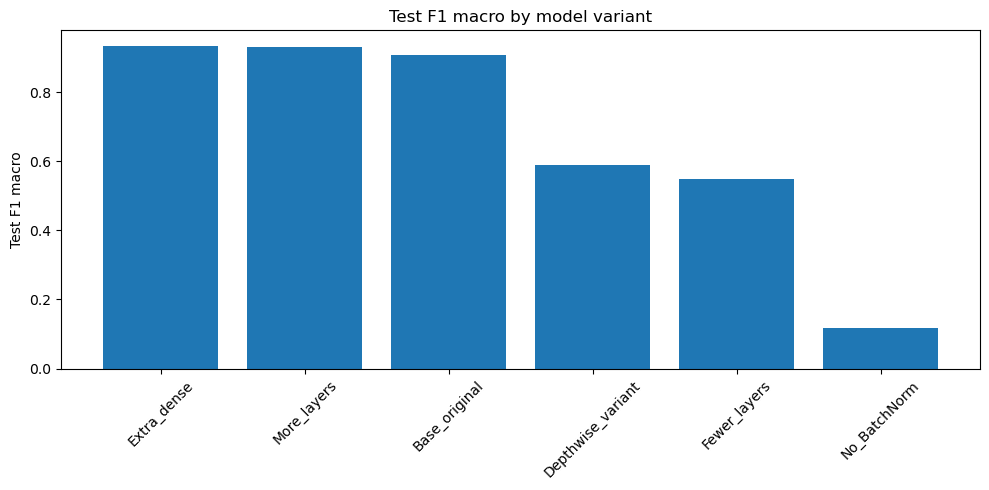

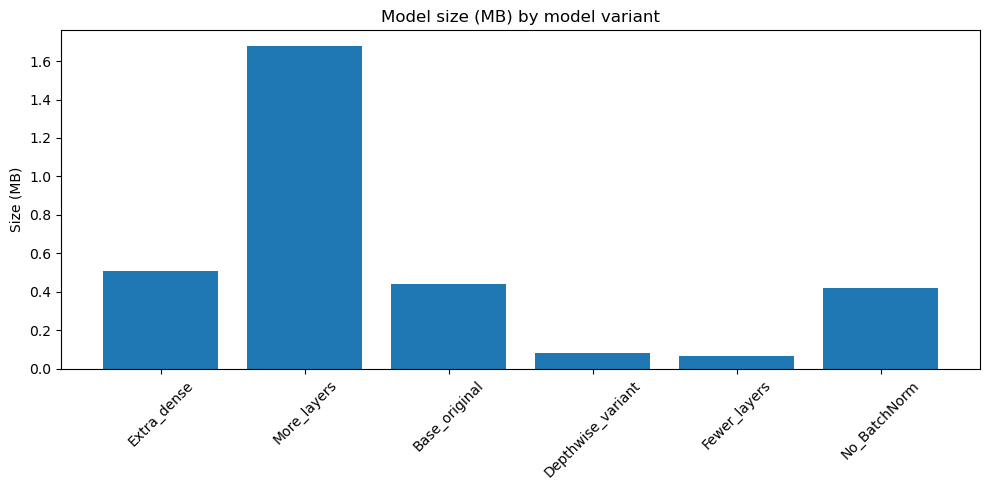

In [7]:
# Cell 7 - quick visualization: test F1 and model size
if not results_df.empty:
    plt.figure(figsize=(10,5))
    plt.bar(results_df['model_name'], results_df['test_f1_macro'])
    plt.title('Test F1 macro by model variant')
    plt.ylabel('Test F1 macro')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.bar(results_df['model_name'], results_df['model_size_mb'])
    plt.title('Model size (MB) by model variant')
    plt.ylabel('Size (MB)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
